In this notebook we are going to translate english sentences to french using encoder-decoder sequence2sequence model. We will use one-hot character vectors as input to the model.

In [58]:
#importing dependencies for preprocessing
import numpy as np
import os

In [59]:
data_path = '../data'
print(os.listdir(data_path))

['a.txt', 'fra-eng.zip', 'fra.txt', '_about.txt']


In [60]:
#fra.txt is our required file, reading all lines from that file
lines=[]
with open(data_path+'/fra.txt',encoding='utf-8') as file:
    lines=file.read().split('\n')

In [61]:
print(len(lines))

145437


In [62]:
#we are going to use only 10,000 samples
lines=lines[0:10000]
print(len(lines),lines[9999])

10000 I'm the teacher.	Je suis la professeur.


In [63]:
english_sentences=[]
french_sentences=[]
char_english=set()
char_french=set()
for l in lines:
    l_component = str(l).split('\t')
    english_line=l_component[0]
    french_line='\t'+l_component[1]+'\n'
    
    english_sentences.append(english_line)
    for c in english_line:
        if c not in char_english:
            char_english.add(c)
      
    french_sentences.append(french_line)
    for c in french_line:
        if c not in char_french:
            char_french.add(c)
            
print(len(english_sentences),len(english_sentences),len(char_english),len(char_french))           

10000 10000 72 93


In [64]:
#converting set to list and creating a dictionary that binds characters to their list indices.
char_english = sorted(list(char_english))
char_french = sorted(list(char_french))

dict_english={}
dict_french={}

for index,element in enumerate(char_english):
    dict_english[element]=index
for index,element in enumerate(char_french):   
    dict_french[element]=index

print(dict_english)
print(dict_french)
    

{' ': 0, '!': 1, '$': 2, '&': 3, "'": 4, ',': 5, '-': 6, '.': 7, '0': 8, '1': 9, '2': 10, '3': 11, '4': 12, '5': 13, '6': 14, '7': 15, '9': 16, ':': 17, '?': 18, 'A': 19, 'B': 20, 'C': 21, 'D': 22, 'E': 23, 'F': 24, 'G': 25, 'H': 26, 'I': 27, 'J': 28, 'K': 29, 'L': 30, 'M': 31, 'N': 32, 'O': 33, 'P': 34, 'Q': 35, 'R': 36, 'S': 37, 'T': 38, 'U': 39, 'V': 40, 'W': 41, 'Y': 42, 'Z': 43, 'a': 44, 'b': 45, 'c': 46, 'd': 47, 'e': 48, 'f': 49, 'g': 50, 'h': 51, 'i': 52, 'j': 53, 'k': 54, 'l': 55, 'm': 56, 'n': 57, 'o': 58, 'p': 59, 'q': 60, 'r': 61, 's': 62, 't': 63, 'u': 64, 'v': 65, 'w': 66, 'x': 67, 'y': 68, 'z': 69, '’': 70, '\ufeff': 71}
{'\t': 0, '\n': 1, ' ': 2, '!': 3, '$': 4, '&': 5, "'": 6, '(': 7, ')': 8, ',': 9, '-': 10, '.': 11, '0': 12, '1': 13, '5': 14, '6': 15, '9': 16, ':': 17, '?': 18, 'A': 19, 'B': 20, 'C': 21, 'D': 22, 'E': 23, 'F': 24, 'G': 25, 'H': 26, 'I': 27, 'J': 28, 'K': 29, 'L': 30, 'M': 31, 'N': 32, 'O': 33, 'P': 34, 'Q': 35, 'R': 36, 'S': 37, 'T': 38, 'U': 39, 'V'

In [65]:
#calculating maximum length of english and french sentences
max_len_english_sent = max(len(sent) for sent in  english_sentences)
max_len_french_sent = max(len(sent) for sent in  french_sentences)

print(max_len_english_sent,max_len_french_sent)

16 59


In [66]:
#defining our input english and french matrices
no_samples=10000
vectorized_english = np.zeros(shape=(no_samples,max_len_english_sent,len(char_english)), dtype='float32')
vectorized_french = np.zeros(shape=(no_samples, max_len_french_sent, len(char_french)), dtype='float32')
#target_data will be french sentences
target_data = np.zeros(shape=(no_samples, max_len_french_sent, len(char_french)), dtype='float32')

print(vectorized_english.shape)
print(vectorized_french.shape)
print(target_data.shape)

(10000, 16, 72)
(10000, 59, 93)
(10000, 59, 93)


In [67]:
#vectorizing sentences
#print(dict_english)
for i in range(no_samples):
    for index,character in enumerate(english_sentences[i]):
        vectorized_english[i,index,dict_english[character]] = 1
    
    for index,character in enumerate(french_sentences[i]):
        vectorized_french[i,index,dict_french[character]] = 1  
         # decoder_target_data will be ahead by one timestep and will not include the start character.
        if index > 0:
            target_data[i,index-1,dict_french[character]] = 1

Now we are going to define our model. First we will define the encoding layer, followed by decoding layer

In [68]:
#loading dependencies for defining our model
from keras.models import Model
from keras.layers import Input, LSTM, Dense

In [69]:
#input to the encoder will be a sentence with each character in the form of one-hot vector
encoder_input = Input(shape=(None, len(char_english)))

#defining input lstm layer... here 256 is the dimensionality of hidden layer
#return_state=true returns the final hidden_state and cell_state that will be used as input to decoder

encoder_LSTM = LSTM(256,return_state=True)

#we are providing sentence as input to lstm,which returns the output(ignore for encoder), final hidden and cell state
encoder_outputs, encoder_final_hidden_state, encoder_final_cell_state = encoder_LSTM(encoder_input)

#these will be used as inputs to the decoder layer
encoder_states = [encoder_final_hidden_state, encoder_final_cell_state]


Now we are going to define the decoder model

In [70]:
#input to decoder will be sentences with french characters in the form of onr-hot vectors
decoder_input = Input(shape=(None,len(char_french)))

#since final state of encoder is used as input to decoder, thus hidden cell dimensionality will be same for both
#return_sequence=True to get all sequence of outputs from LSTM
#return_state=True to get final state of hidden and cell units
decoder_LSTM=LSTM(256,return_sequences=True, return_state=True)

#note we are using final encoder states as initial decoder states
decoder_out, decoder_final_hidden_state, decoder_final_cell_state=decoder_LSTM(decoder_input, initial_state=encoder_states)

#making a dense layer to predict the decoded character and learn from its loss generated using softmax classifier
#the dimensionality of dence layer will be length of char_french
decoder_dense = Dense(len(char_french),activation='softmax')

#giving output of decoder layer to the dense layer to predict the final output
decoder_out = decoder_dense(decoder_out)

A Dense output layer is used to predict each character. This Dense is used to produce each character in the output sequence in a one-shot manner, rather than recursively, at least during training. This is because the entire target sequence required for input to the model is known during training.

In [71]:
#now we are going to define the model
model = Model([encoder_input, decoder_input] ,outputs= decoder_out)

#plotting graph for better visualization of model
import pydot
from keras.utils.vis_utils import plot_model

plot_model(model, to_file='model.png',show_shapes=True)

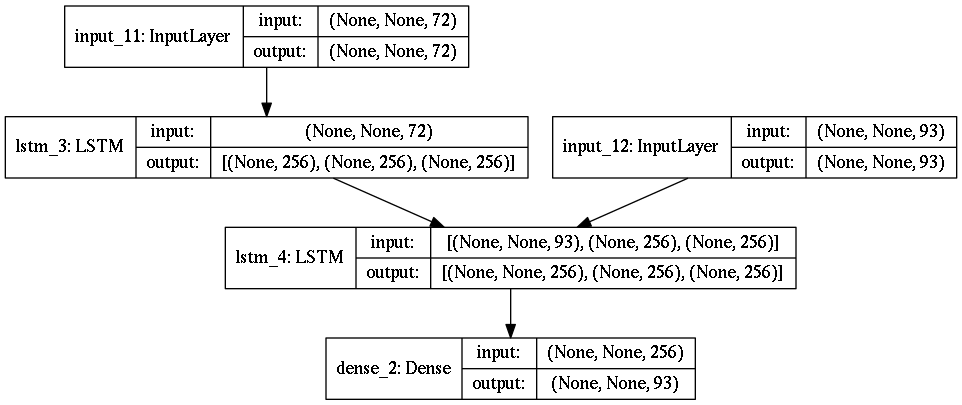

In [72]:
#displaying model 
from IPython.display import Image
Image(filename='model.png') 

In [73]:
#Now it's time to compile the model
model.compile(optimizer='rmsprop', loss='categorical_crossentropy')
print(model.summary())

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           (None, None, 72)     0                                            
__________________________________________________________________________________________________
input_12 (InputLayer)           (None, None, 93)     0                                            
__________________________________________________________________________________________________
lstm_3 (LSTM)                   [(None, 256), (None, 336896      input_11[0][0]                   
__________________________________________________________________________________________________
lstm_4 (LSTM)                   [(None, None, 256),  358400      input_12[0][0]                   
                                                                 lstm_3[0][1]                     
          

In [74]:
#fitting model
%time model.fit(x=[vectorized_english,vectorized_french],y=target_data,batch_size=64,epochs=50, validation_split=0.2)

Train on 8000 samples, validate on 2000 samples
Epoch 1/50
8000/8000 [==============================] - 81s 10ms/step - loss: 0.9237 - val_loss: 0.9511
Epoch 2/50
8000/8000 [==============================] - 83s 10ms/step - loss: 0.7277 - val_loss: 0.7905
Epoch 3/50
8000/8000 [==============================] - 80s 10ms/step - loss: 0.6215 - val_loss: 0.7089
Epoch 4/50
8000/8000 [==============================] - 80s 10ms/step - loss: 0.5669 - val_loss: 0.6616
Epoch 5/50
8000/8000 [==============================] - 80s 10ms/step - loss: 0.5263 - val_loss: 0.6340
Epoch 6/50
8000/8000 [==============================] - 80s 10ms/step - loss: 0.4943 - val_loss: 0.6052
Epoch 7/50
8000/8000 [==============================] - 80s 10ms/step - loss: 0.4687 - val_loss: 0.5852
Epoch 8/50
8000/8000 [==============================] - 80s 10ms/step - loss: 0.4460 - val_loss: 0.5642
Epoch 9/50
8000/8000 [==============================] - 80s 10ms/step - loss: 0.4271 - val_loss: 0.5519
Epoch 10/50
8000

Now it's time to create inference model. 
The architecture of inference model looks like this.

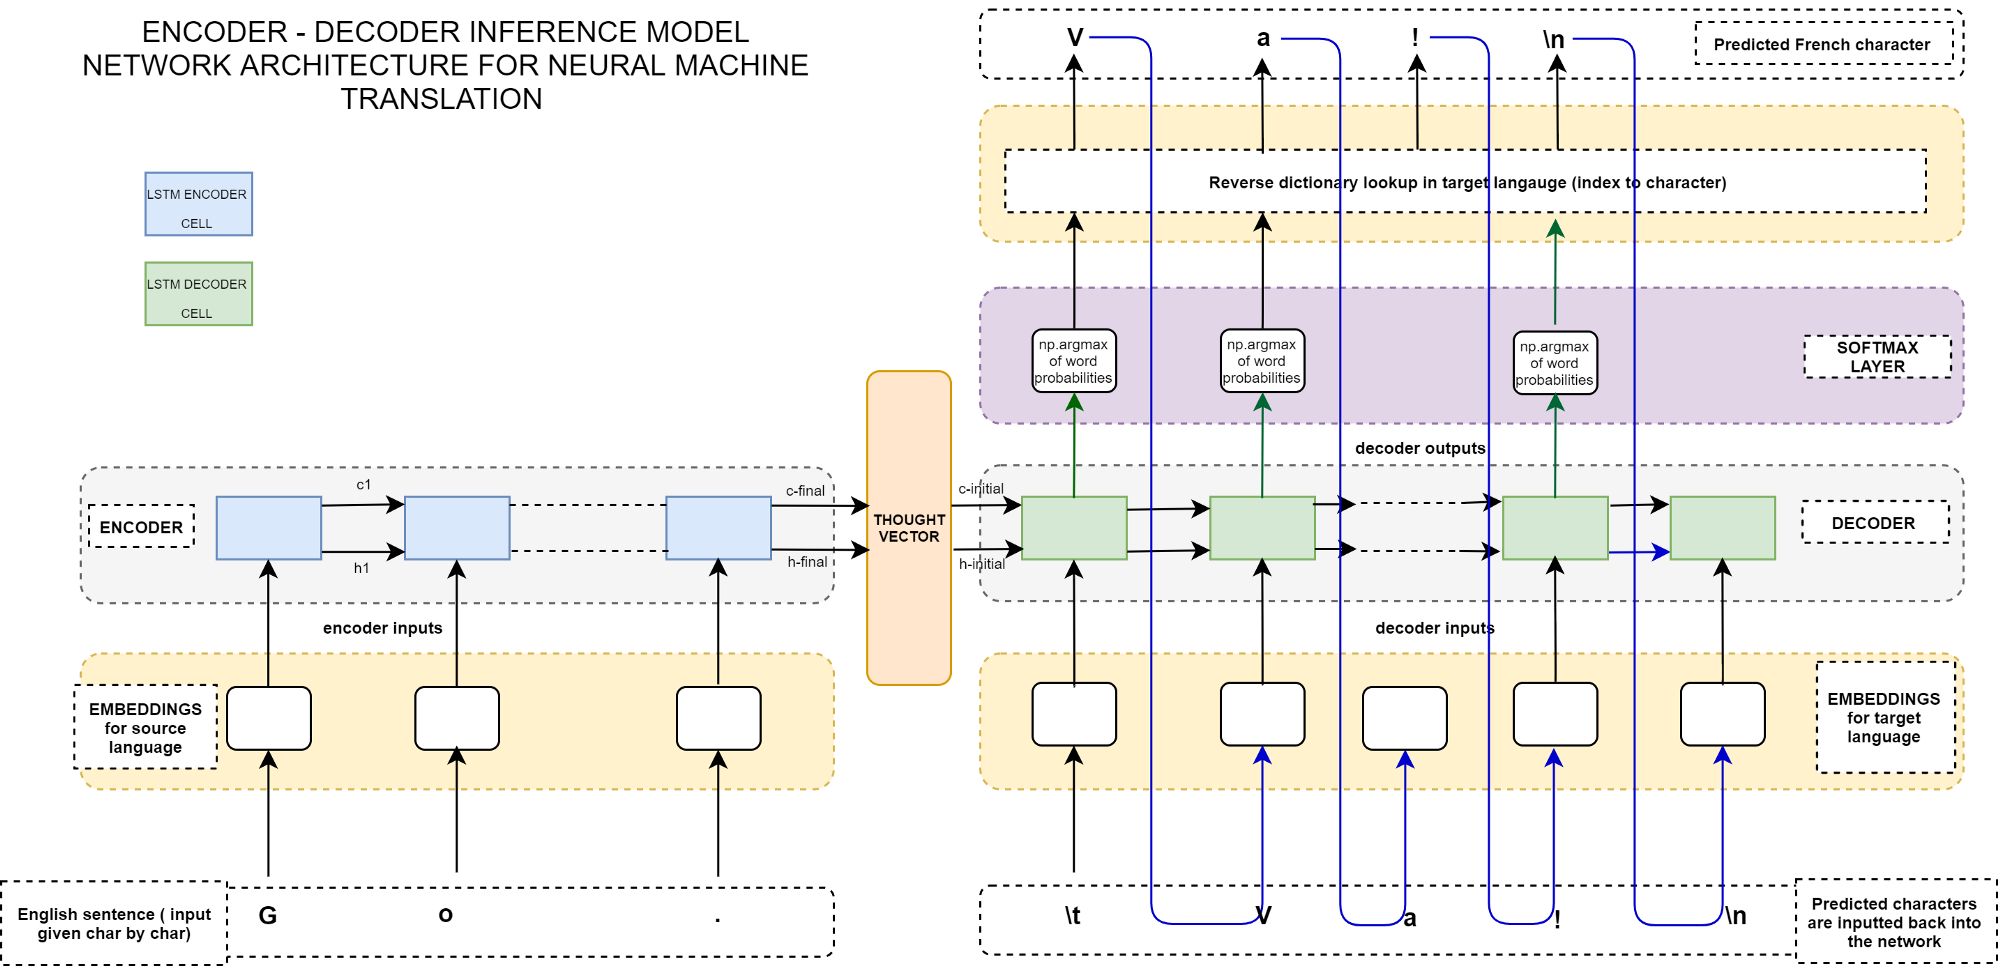

In [75]:
Image(filename="sample_inference_model.png")

Now we are going to define interface model for translating from english to french


In [76]:
#Interface Model

#encoding step
encoding_model_inf = Model(encoder_input,encoder_states) 

In [77]:
#Decoder Interface Model
# Decoder inference model
decoder_state_input_h = Input(shape=(256,))
decoder_state_input_c = Input(shape=(256,))
decoder_input_states = [decoder_state_input_h, decoder_state_input_c]

decoder_out, decoder_h, decoder_c = decoder_LSTM(decoder_input, 
                                                 initial_state=decoder_input_states)

decoder_states = [decoder_h , decoder_c]

decoder_out = decoder_dense(decoder_out)

decoder_model_inf = Model(inputs=[decoder_input] + decoder_input_states,
                          outputs=[decoder_out] + decoder_states )

In [78]:
#defining a function to decode a sequence
def dec_seq(input_seq):
    #initial states value is coming from encoder
    states_val = encoding_model_inf.predict(input_seq)
    
    #predicted target sequence at every time step from model
    target_seq = np.zeros(shape=(1,1,len(char_french)))
    
    #first character fed as input to decoder is always '\t' right from training
    target_seq[0,-1,dict_french['\t']]=1
    
    translated_seq=''
    
    stop_condition = False
    
    while not stop_condition:
        decoder_out, decoder_h,decoder_c = decoder_model_inf.predict(x=[target_seq] + states_val)
     #   decoder_out, decoder_h, decoder_c = decoder_model_inf.predict(x=[target_seq] + states_val)
        #getting index of maximum probability
        max_val_index = np.argmax(decoder_out[0,-1,:])
        
        #adding predicted character to translated sentence
        translated_seq+=char_french[max_val_index]
        
        #if predicted character is '\n' or length of translated sentence exceeds maximum permitted length
        #then stop_condition= True
        
        if (char_french[max_val_index]=='\n') or (len(translated_seq) > max_len_french_sent):
            stop_condition=True
            
        #setting target_seq as predicted word 
        target_seq = np.zeros(shape=(1,1,len(char_french)))
        target_seq[0,-1,max_val_index]=1
        
        #resetting the decoder state to new values
        states_val = [decoder_h,decoder_c]
    
    return translated_seq

In [113]:
#plotting encoder_interface model
plot_model(encoding_model_inf, to_file='encoding_model.png',show_shapes=True)

plot_model(decoder_model_inf, to_file='decoding_model_inf.png',show_shapes=True)


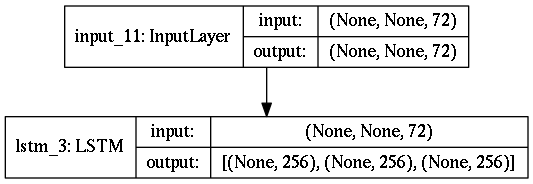

In [114]:
Image(filename="encoding_model.png")

In [ ]:
#decoding_model_inf


In [110]:
for i in range(50,100):
    print('englih sentence ',english_sentences[i])
    print('french_translation',dec_seq(vectorized_english[i:i+1]))


englih sentence  No way!
french_translation C'est pas possible !

englih sentence  Really?
french_translation Vraiment ?

englih sentence  Really?
french_translation Vraiment ?

englih sentence  Really?
french_translation Vraiment ?

englih sentence  Thanks.
french_translation Merci !

englih sentence  We try.
french_translation Soyez raisonnables !

englih sentence  We won.
french_translation Nous l'avons emporté.

englih sentence  We won.
french_translation Nous l'avons emporté.

englih sentence  We won.
french_translation Nous l'avons emporté.

englih sentence  We won.
french_translation Nous l'avons emporté.

englih sentence  Ask Tom.
french_translation Demande à Tom.

englih sentence  Awesome!
french_translation Cont passons de proîter.

englih sentence  Be calm.
french_translation Sois calme !

englih sentence  Be calm.
french_translation Sois calme !

englih sentence  Be calm.
french_translation Sois calme !

englih sentence  Be cool.
french_translation Sois détentu !

englih se

In [111]:
for i in range(100,200):
    print('englih sentence ',english_sentences[i])
    print('french_translation',dec_seq(vectorized_english[i:i+1]))


englih sentence  Get out.
french_translation Allez chercher un médecin !

englih sentence  Go away!
french_translation Pars !

englih sentence  Go away!
french_translation Pars !

englih sentence  Go away.
french_translation Va t'en !

englih sentence  Go away.
french_translation Va t'en !

englih sentence  Go away.
french_translation Va t'en !

englih sentence  Go away.
french_translation Va t'en !

englih sentence  Go away.
french_translation Va t'en !

englih sentence  Go away.
french_translation Va t'en !

englih sentence  Go away.
french_translation Va t'en !

englih sentence  Go away.
french_translation Va t'en !

englih sentence  Go slow.
french_translation Va doucement !

englih sentence  Go slow.
french_translation Va doucement !

englih sentence  Goodbye!
french_translation Laisse tomber !

englih sentence  Hang on!
french_translation Attendez un peu !

englih sentence  Hang on!
french_translation Attendez un peu !

englih sentence  Hang on.
french_translation Tenez bon !

en